In this notebook, we explore the application of Directed Acyclic Graph (DAG)-based Graph Neural Networks (GNNs) to learn a diffusion model over a DAG structure. The objective is to test whether different an architectures are capable of predicting the output signals given some sparse inputs. Leveraging the inherent structure of the DAG will play a fundamental role in the performance of the considered architectures.

We investigate various settings to understand their impact on the diffusion process and prediction accuracy. These settings include:
- The number of DAG-based Graph Signal Operators (GSOs) involved in the diffusion process.
- The number of seeding nodes (sources) from which the diffusion starts.
- The influence of selecting different transitive closures on the diffusion process.

By experimenting with these settings, we aim to gain insights into how different configurations affect the performance and efficiency of the diffusion model. Ultimately, our goal is to develop an optimized architecture that can effectively capture and utilize the underlying structure of the DAG for accurate predictions.

In [1]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
import time
import dgl
import torch
from torch import nn
from torch.nn import functional as F

import src.dag_utils as dagu
import src.utils as utils
from src.arch import DAGConv, FB_DAGConv, SF_DAGConv
from src.models import Model, LinDAGRegModel
from src.baselines_archs import GCNN_2L, GCNN, GAT, MLP, MyGCNN, GraphSAGE, GIN

import os

# Ser random seed
SEED = 10
PATH = 'results/diffusion/'
SAVE = False
np.random.seed(SEED)
torch.manual_seed(SEED)
dgl.random.seed(SEED)

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
# torch.cuda.set_per_process_memory_fraction(.5, device=device)

## Default parameters and auxiliary functions

In [2]:
M = 2000

data_p = {
    'n_tries': 25,

    ## Graph parameters
    'p': 0.2,                    # Edge prob in Erdos-Renyi DAG
    'N': 100,                    # Number of nodes

    ## Signal parameters
    'M': M,                   # Number of observed signals
    'M_train': int(0.7 * M),  # Samples selected for training
    'M_val': int(0.2 * M),    # Samples selected for validation
    'M_test': int(0.1 * M),   # Samples selected for test
    'src_t': 'constant',          # 'random' or 'constant'
    'max_src_node': 15,           # Maximum index of nodes allowed to be sources
    'n_sources': 5,              # Maximum Number of source nodes
    'n_p': .05,                 # Normalized noise power
    'max_GSO': 100,              # Maximum index of GSOs involved in the diffusion
    'min_GSO': 50,               # Minimum index of GSOs involved in the diffusion
    'n_GSOs': 25                 # Number of GSOs
}

# Model parameters
default_arch_p = {
    'in_dim': 1,        # Input dimension
    'hid_dim': 16,     # Hidden dimension
    'out_dim': 1,       # Output dimension
    'L': 2,  # 3 also works well          # Number of layers
    'l_act': None,
}

default_mod_p = {
    'bs': 25,           # Size of the batch
    'lr': 5e-4,         # Learning rate
    'epochs': 50,       # Number of training epochs 
    'pat': 15,          # Number of non-decreasing epoch to stop training
    'wd': 1e-4,         # Weight decay
}

In [3]:
def get_signals(d_p, GSOs):
    range_GSO = np.arange(d_p['min_GSO'], d_p['max_GSO'])
    gsos_idx = np.random.choice(range_GSO, size=d_p['n_GSOs'], replace=False)
    sel_GSOs = GSOs[gsos_idx]
    Y_t, X_t = dagu.create_diff_data(d_p['M'], sel_GSOs, d_p['max_src_node'], d_p['n_p'],
                                         d_p['n_sources'], src_t=d_p['src_t'], torch_tensor=True)
    
    X_data = {'train': X_t[:d_p['M_train']], 'val': X_t[d_p['M_train']:-d_p['M_test']], 'test': X_t[-d_p['M_test']:]}
    Y_data = {'train': Y_t[:d_p['M_train']], 'val': Y_t[d_p['M_train']:-d_p['M_test']], 'test': Y_t[-d_p['M_test']:]}
    return X_data, Y_data, sel_GSOs

def run_exps(exps, d_arc_p, d_mod_p, d_dat_p, GSOs, W, Adj, Psi=None, exp_desc='default'):
    err_exps = np.zeros(len(exps))
    std_exps = np.zeros(len(exps))
    times_exps = np.zeros(len(exps))
    for k, exp in enumerate(exps):
        arc_p = {**d_arc_p, **exp['arc_p']}
        mod_p = {**d_mod_p, **exp['mod_p']} if 'mod_p' in exp else d_mod_p
        d_p = {**d_dat_p, **exp['dat_p']} if 'dat_p' in exp else d_dat_p

        X_data, Y_data, sel_GSOs = get_signals(d_p, GSOs)

        if exp['arc_p']['arch'] == LinDAGRegModel:
            
            lin_model = LinDAGRegModel(W, Psi)
            t_i = time.time()
            lin_model.fit(X_data['train'], Y_data['train'])
            t_e = time.time() - t_i

            err_exps[k], std_exps[k] = lin_model.test(X_data['test'], Y_data['test'])
        else:
            GSO = utils.select_GSO(arc_p, GSOs, sel_GSOs, W, Adj)
            K = GSO.shape[0] if isinstance(GSO, torch.Tensor) and len(GSO.shape) == 3 else 0  
            arch = utils.instantiate_arch(arc_p, K)
            model = Model(arch, device=device)

            t_i = time.time()
            model.fit(X_data, Y_data, GSO, mod_p['lr'], mod_p['epochs'], mod_p['bs'], mod_p['wd'],
                    patience=mod_p['pat'])
            t_e = time.time() - t_i

            err_exps[k], std_exps[k] = model.test(X_data['test'], Y_data['test'], GSO)
        times_exps[k] = t_e
        print(f'\t-{exp_desc}. {exp["leg"]}: err: {err_exps[k]:.3f} - time: {times_exps[k]:.1f}')

    return err_exps, std_exps, times_exps

def run_exp(d_p, d_arc_p, d_mod_p, exps):
    err = np.zeros((d_p['n_tries'], len(exps)))
    std = np.zeros((d_p['n_tries'], len(exps)))
    times = np.zeros((d_p['n_tries'], len(exps)))

    t_begin = time.time()
    for i in range(d_p['n_tries']):
        Adj, W, GSOs, Psi = utils.get_graph_data(d_p, get_Psi=True)
        X_data, Y_data, sel_GSOs = get_signals(d_p, GSOs)
        
        for j, exp in enumerate(exps):
            arc_p = {**d_arc_p, **exp['arc_p']}
            mod_p = {**d_mod_p, **exp['mod_p']} if 'mod_p' in exp.keys() else d_mod_p



            if exp['arc_p']['arch'] == LinDAGRegModel:
                lin_model = LinDAGRegModel(W, Psi)
                t_i = time.time()
                lin_model.fit(X_data['train'], Y_data['train'])
                t_e = time.time() - t_i

                err[i,j], std[i,j] = lin_model.test(X_data['test'], Y_data['test'])
            else:
                GSO = utils.select_GSO(arc_p, GSOs, sel_GSOs, W, Adj)

                K = GSO.shape[0] if isinstance(GSO, torch.Tensor) and len(GSO.shape) == 3 else 0  
                arch = utils.instantiate_arch(arc_p, K)
                model = Model(arch, device=device)

                t_i = time.time()
                model.fit(X_data, Y_data, GSO, mod_p['lr'], mod_p['epochs'], mod_p['bs'], mod_p['wd'],
                        patience=mod_p['pat'])
                t_e = time.time() - t_i
                err[i,j], std[i,j] = model.test(X_data['test'], Y_data['test'], GSO)

            times[i,j] = t_e

            print(f'-{i}. {exp["leg"]}: err: {err[i,j]:.3f} - time: {times[i,j]:.1f}')

    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')
    return err, std, times

## Initial test

In [4]:
# Experiments to be run
Exps = [
    {'arc_p': {'arch': LinDAGRegModel}, 'leg': 'Linear'},

    {'arc_p': {'arch': DAGConv, 'GSO': 'GSOs'}, 'mod_p': {}, 'leg': 'DAGCNN'},
    {'arc_p': {'arch': DAGConv, 'GSO': 'sel_GSOs'}, 'mod_p': {}, 'leg': 'DAGCNN-Prior'},
    {'arc_p': {'arch': DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 5}, 'mod_p': {}, 'leg': 'DAGCNN-Rnd-5'},
    {'arc_p': {'arch': DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 15}, 'mod_p': {}, 'leg': 'DAGCNN-Rnd-15'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'mod_p': {}, 'leg': 'FB-DAGCNN'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'sel_GSOs'}, 'mod_p': {}, 'leg': 'FB-DAGCNN-Prior'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 5}, 'mod_p': {}, 'leg': 'FB-DAGCNN-Rnd-5'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 15}, 'mod_p': {}, 'leg': 'FB-DAGCNN-Rnd-15'},

    {'arc_p': {'arch': MyGCNN, 'GSO': 'A'}, 'mod_p': {}, 'leg': 'My-GNN-A'},
    {'arc_p': {'arch': MyGCNN, 'GSO': 'W'}, 'mod_p': {}, 'leg': 'My-GNN-W'},

    {'arc_p': {'arch': GAT, 'GSO': 'A-dgl', 'n_heads': 2, 'hid_dim': 16, 'gat_params': {'attn_drop': 0}},
     'mod_p': {}, 'leg': 'GAT-A'},
    {'arc_p': {'arch': GraphSAGE, 'GSO': 'A-dgl', 'hid_dim': 16, 'agg': 'mean'}, 'leg': 'GraphSAGE-A'},
    {'arc_p': {'arch': GIN, 'GSO': 'A-dgl', 'hid_dim': 16, 'agg': 'sum'}, 'leg': 'GIN-A'},
    {'arc_p': {'arch': MLP, 'GSO': None}, 'mod_p': {}, 'leg': 'MLP'},    
    ]

err, std, times = run_exp(data_p, default_arch_p, default_mod_p, Exps)

-0. Linear: err: 0.017 - time: 0.3
-0. DAGCNN: err: 0.079 - time: 8.5
-0. DAGCNN-Prior: err: 0.035 - time: 5.1
-0. DAGCNN-Rnd-5: err: 0.048 - time: 5.1
-0. DAGCNN-Rnd-15: err: 0.034 - time: 5.2
-0. FB-DAGCNN: err: 0.019 - time: 3.8
-0. FB-DAGCNN-Prior: err: 0.021 - time: 3.5
-0. FB-DAGCNN-Rnd-5: err: 0.046 - time: 3.8
-0. FB-DAGCNN-Rnd-15: err: 0.029 - time: 3.8
-0. My-GNN-A: err: 0.133 - time: 3.6
-0. My-GNN-W: err: 0.441 - time: 3.7
-0. GAT-A: err: 0.442 - time: 14.6
-0. GraphSAGE-A: err: 0.190 - time: 6.2
-0. GIN-A: err: 0.230 - time: 6.6
-0. MLP: err: 0.194 - time: 1.7
-1. Linear: err: 0.028 - time: 0.3
-1. DAGCNN: err: 0.054 - time: 8.2
-1. DAGCNN-Prior: err: 0.045 - time: 4.9
-1. DAGCNN-Rnd-5: err: 0.056 - time: 4.8
-1. DAGCNN-Rnd-15: err: 0.065 - time: 4.8
-1. FB-DAGCNN: err: 0.027 - time: 3.8
-1. FB-DAGCNN-Prior: err: 0.029 - time: 3.7
-1. FB-DAGCNN-Rnd-5: err: 0.038 - time: 3.3
-1. FB-DAGCNN-Rnd-15: err: 0.034 - time: 3.4
-1. My-GNN-A: err: 0.185 - time: 3.4
-1. My-GNN-W: err:

In [5]:
# DEFAULT PARAMETERS
if SAVE:
    file_name = PATH + f'init_exp-{data_p["src_t"]}'
    np.savez(file_name, err=err, std=std, times=times)
    print('SAVED FILE:', file_name)

leg = [exp['leg'] for exp in Exps]
utils.display_data(leg, err, std, times)

SAVED FILE: results/diffusion/init_exp-constant


,Exp,Mean Err,Median Err,Mean Std,time
0,Linear,0.032051,0.025551,0.019546,0.331648
1,DAGCNN,0.217937,0.090916,0.047917,8.401889
2,DAGCNN-Prior,0.130055,0.055192,0.037231,4.907997
3,DAGCNN-Rnd-5,0.143621,0.062468,0.040348,4.849560
4,DAGCNN-Rnd-15,0.123110,0.067286,0.040146,4.913089
5,FB-DAGCNN,0.033578,0.026805,0.016397,3.647211
6,FB-DAGCNN-Prior,0.035587,0.028550,0.018684,3.655249
7,FB-DAGCNN-Rnd-5,0.109478,0.057311,0.036444,3.411590
8,FB-DAGCNN-Rnd-15,0.082803,0.039230,0.030468,3.500523
9,My-GNN-A,0.237945,0.167201,0.040419,3.491738


## Influence of selected GSOs

In [ ]:
def influence_gso_exp(d_dat_p, d_arc_p, d_mod_p, N_GSOs, exps):
    err = np.zeros((d_dat_p['n_tries'], len(N_GSOs), len(exps)))
    std = np.zeros((d_dat_p['n_tries'], len(N_GSOs), len(exps)))
    times = np.zeros((d_dat_p['n_tries'], len(N_GSOs), len(exps)))
    t_begin = time.time()

    for i in range(d_dat_p['n_tries']):
        print('Iteration:', i)

        Adj, W, GSOs = utils.get_graph_data(d_dat_p)

        for j, n_gsos in enumerate(N_GSOs):
            data_params_aux = dict(d_dat_p)
            data_params_aux['n_GSOs'] = n_gsos
            err[i,j], std[i,j], times[i,j] = run_exps(exps, d_arc_p, d_mod_p, data_params_aux, GSOs, W, Adj)

    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')
    return err, std, times


In [ ]:
Exps = [
    {'dat_p': {'min_GSO': 0, 'max_GSO': 100}, 'arc_p': {'arch': DAGConv, 'GSO': 'GSOs'}, 'mod_p': {},
     'leg': 'DAGCNN, All', 'fmt': 'v-'},
    {'dat_p': {'min_GSO': 0, 'max_GSO': 100}, 'arc_p': {'arch': DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 5},
     'mod_p': {}, 'leg': 'DAGCNN-Rnd-5, All', 'fmt': '^-'},
    {'dat_p': {'min_GSO': 0, 'max_GSO': 100}, 'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'mod_p': {},
     'leg': 'FB-DAGCNN, All', 'fmt': 'o-'},
    {'dat_p': {'min_GSO': 0, 'max_GSO': 100}, 'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 5},
     'mod_p': {}, 'leg': 'FB-DAGCNN-Rnd-5, All', 'fmt': 's-'},

    {'dat_p': {'min_GSO': 0, 'max_GSO': 50}, 'arc_p': {'arch': DAGConv, 'GSO': 'GSOs'}, 'mod_p': {},
     'leg': 'DAGCNN, Firsts', 'fmt': 'v--'},
    {'dat_p': {'min_GSO': 0, 'max_GSO': 50}, 'arc_p': {'arch': DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 5}, 'mod_p': {}, 
     'leg': 'DAGCNN-Rnd, Firsts', 'fmt': '^--'},
    {'dat_p': {'min_GSO': 0, 'max_GSO': 50}, 'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'mod_p': {},
     'leg': 'FB-DAGCNN, Firsts', 'fmt': 'o--'},
    {'dat_p': {'min_GSO': 0, 'max_GSO': 50}, 'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 5},
     'mod_p': {}, 'leg': 'FB-DAGCNN-Rnd, Firsts', 'fmt': 's--'},

    {'dat_p': {'min_GSO': 50, 'max_GSO': 100}, 'arc_p': {'arch': DAGConv, 'GSO': 'GSOs'}, 'mod_p': {},
     'leg': 'DAGCNN, Lasts', 'fmt': 'v:'},
    {'dat_p': {'min_GSO': 50, 'max_GSO': 100}, 'arc_p': {'arch': DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 5}, 'mod_p': {}, 
     'leg': 'DAGCNN-Rnd, Lasts', 'fmt': '^:'},
    {'dat_p': {'min_GSO': 50, 'max_GSO': 100}, 'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'mod_p': {},
     'leg': 'FB-DAGCNN, Lasts', 'fmt': 'o:'},
    {'dat_p': {'min_GSO': 50, 'max_GSO': 100}, 'arc_p': {'arch': FB_DAGConv, 'GSO': 'sel_GSOs'}, 'mod_p': {},
     'leg': 'FB-DAGCNN-Rnd, Lasts', 'fmt': 's:'},
    ]

N_GSOs = np.arange(5, 41, 5)

err, std, times = influence_gso_exp(data_p, default_arch_p, default_mod_p, N_GSOs, Exps)

In [ ]:
if SAVE:
    file_name = PATH + f'gso_inf-{data_p["src_t"]}'
    np.savez(file_name, err=err, std=std, times=times, exp=Exps, xvals=N_GSOs)
    print('SAVED FILE:', file_name)

mean_err = err.mean(axis=0)
med_err = np.median(err, axis=0)

skip_idx = [2, 3, 6, 7, 10, 11]
utils.plot_results(med_err, N_GSOs, Exps, 'Number of GSOs involved in the filter',
                   skip_idx=skip_idx, n_cols=3)

skip_idx = [0, 1, 4, 5, 8, 9]
utils.plot_results(med_err, N_GSOs, Exps, 'Number of GSOs involved in the filter',
                   skip_idx=skip_idx, n_cols=3)

In [ ]:
# file_name = PATH + 'gso_inf-constant.npz'
# err, std, times, Exps, N_sources = utils.load_data(file_name)

## Influence of the number of source nodes

In [ ]:
def influence_sources_exp(d_dat_p, d_arc_p, d_mod_p, N_sources, exps):
    err = np.zeros((d_dat_p['n_tries'], len(N_sources), len(exps)))
    std = np.zeros((d_dat_p['n_tries'], len(N_sources), len(exps)))
    times = np.zeros((d_dat_p['n_tries'], len(N_sources), len(exps)))
    
    t_begin = time.time()
    for i in range(d_dat_p['n_tries']):
        print('Iteration:', i)

        Adj, W, GSOs = utils.get_graph_data(d_dat_p)

        for j, n_sources in enumerate(N_sources):
            data_params_aux = dict(d_dat_p)
            data_params_aux['n_sources'] = n_sources
            err[i,j], std[i,j], times[i,j] = run_exps(exps, d_arc_p, d_mod_p, data_params_aux, GSOs, W,
                                                      Adj, exp_desc=str(n_sources))

    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')
    return err, std, times

In [ ]:
M = 2000
data_soruces = dict(data_p)
data_soruces['max_src_node'] = 25

N_sources = [1, 5, 10, 15, 20, 25]

Exps = [
    {'arc_p': {'arch': DAGConv, 'GSO': 'GSOs'}, 'mod_p': {}, 'leg': 'DAGCNN', 'fmt': 'o-'},
    {'arc_p': {'arch': DAGConv, 'GSO': 'sel_GSOs'}, 'mod_p': {}, 'leg': 'DAGCNN-Prior', 'fmt': 'P-'},
    {'arc_p': {'arch': DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 5}, 'mod_p': {}, 'leg': 'DAGCNN-Rnd', 'fmt': 's-'},

    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'mod_p': {}, 'leg': 'FB-DAGCNN', 'fmt': 'o--'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'sel_GSOs'}, 'mod_p': {}, 'leg': 'FB-DAGCNN-Prior', 'fmt': 'P--'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 5}, 'mod_p': {}, 'leg': 'FB-DAGCNN-Rnd', 'fmt': 's--'},

    {'arc_p': {'arch': MyGCNN, 'GSO': 'A'}, 'mod_p': {}, 'leg': 'GNN-A', 'fmt': 'v:'},
    {'arc_p': {'arch': MyGCNN, 'GSO': 'W'}, 'mod_p': {}, 'leg': 'GNN-W', 'fmt': '^:'},
    {'arc_p': {'arch': MLP, 'GSO': None}, 'mod_p': {}, 'leg': 'MLP', 'fmt': '>:'},
    ]

err, std, times = influence_sources_exp(data_soruces, default_arch_p, default_mod_p, N_sources, Exps)


In [ ]:
if SAVE:
    file_name = PATH + f'src_nodes_inf-{data_p["src_t"]}'
    np.savez(file_name, err=err, std=std, times=times, exp=Exps, xvals=N_sources)
    print('SAVED FILE:', file_name)

mean_err = err.mean(axis=0)
med_err = np.median(err, axis=0)
legend = [exp['leg'] for exp in Exps]
utils.plot_results(med_err, N_sources, Exps, 'Number of soruce nodes', ylim_bottom=1e-3)


In [ ]:
# file_name = PATH + 'src_nodes_inf-constant.npz'
# err, std, times, Exps, N_sources = utils.load_data(file_name)

## Number of randomly selected GSOs

In [ ]:
def influence_selected_gsp_exp(d_dat_p, d_arc_p, d_mod_p, N_GSOs, exps):
    err = np.zeros((d_dat_p['n_tries'], len(N_GSOs), len(exps)))
    std = np.zeros((d_dat_p['n_tries'], len(N_GSOs), len(exps)))
    times = np.zeros((d_dat_p['n_tries'], len(N_GSOs), len(exps)))
    
    t_begin = time.time()
    for i in range(d_dat_p['n_tries']):
        print('Realization:', i)

        Adj, W, GSOs = utils.get_graph_data(d_dat_p)

        for j, n_gsos in enumerate(N_GSOs):
            arch_params_aux = dict(d_arc_p)
            arch_params_aux['n_gsos'] = n_gsos

            err[i,j], std[i,j], times[i,j] = run_exps(exps, arch_params_aux, d_mod_p, d_dat_p, GSOs, W,
                                                      Adj, exp_desc=str(n_gsos))

    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')
    return err, std, times

### Data generated with last GSOs

In [ ]:
M = 2000
N_GSOs = [5, 10, 15, 20, 25, 30, 45, 50, 55, 60]

Exps = [
    {'arc_p': {'arch': DAGConv, 'GSO': 'GSOs'}, 'leg': 'DAGCNN', 'fmt': 'o-'},
    {'arc_p': {'arch': DAGConv, 'GSO': 'sel_GSOs'}, 'leg': 'DAGCNN-Prior', 'fmt': 'P-'},
    {'arc_p': {'arch': DAGConv, 'GSO': 'rnd_GSOs'}, 'leg': 'DAGCNN-Rnd', 'fmt': 's-'},


    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'leg': 'FB-DAGCNN', 'fmt': 'o--'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'sel_GSOs'}, 'leg': 'FB-DAGCNN-Prior', 'fmt': 'P--'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'first_GSOs'}, 'leg': 'FB-DAGCNN-first', 'fmt': 'v--'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'last_GSOs'}, 'leg': 'FB-DAGCNN-last', 'fmt': '^--'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs'}, 'leg': 'FB-DAGCNN-Rnd', 'fmt': 's--'},
]

err, std, times = influence_selected_gsp_exp(data_p, default_arch_p, default_mod_p, N_GSOs, Exps)


In [ ]:
if SAVE:
    file_name = PATH + f'sel_gso_inf-{data_p["src_t"]}'
    np.savez(file_name, err=err, std=std, times=times, exp=Exps, xvals=N_GSOs)
    print('SAVED FILE:', file_name)

mean_err = err.mean(axis=0)
mean_time = times.mean(axis=0)
med_err = np.median(err, axis=0)
med_time = np.median(times, axis=0)
legend = [exp['leg'] for exp in Exps]
utils.plot_results(med_err, N_GSOs, Exps, 'Number of sel GSOs', n_cols=2)
utils.plot_results(med_time, N_GSOs, Exps, 'Number of sel GSOs', ylabel='Mean time (seg)', n_cols=2,
                   logy=False, ylim_bottom=1, ylim_top=12)

### Data generated with all GSOs

In [ ]:
data_rnd_gsos = dict(data_p)
data_rnd_gsos['min_GSO'] = 0
data_rnd_gsos['max_GSO'] = 100

M = 2000
N_GSOs = [5, 10, 15, 20, 25, 30, 45, 50, 55, 60]

Exps = [
    {'arc_p': {'arch': DAGConv, 'GSO': 'GSOs'}, 'leg': 'DAGCNN', 'fmt': 'o-'},
    {'arc_p': {'arch': DAGConv, 'GSO': 'sel_GSOs'}, 'leg': 'DAGCNN-Prior', 'fmt': 'P-'},
    {'arc_p': {'arch': DAGConv, 'GSO': 'rnd_GSOs'}, 'leg': 'DAGCNN-Rnd', 'fmt': 's-'},


    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'leg': 'FB-DAGCNN', 'fmt': 'o--'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'sel_GSOs'}, 'leg': 'FB-DAGCNN-Prior', 'fmt': 'P--'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'first_GSOs'}, 'leg': 'FB-DAGCNN-first', 'fmt': 'v--'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'last_GSOs'}, 'leg': 'FB-DAGCNN-last', 'fmt': '^--'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs'}, 'leg': 'FB-DAGCNN-Rnd', 'fmt': 's--'},
]

err, std, times = influence_selected_gsp_exp(data_rnd_gsos, default_arch_p, default_mod_p, N_GSOs, Exps)


In [ ]:
if SAVE:
    file_name = PATH + f'sel_gso_inf-from_all_gso-{data_p["src_t"]}'
    np.savez(file_name, err=err, std=std, times=times, exp=Exps, xvals=N_GSOs)
    print('SAVED FILE:', file_name)

mean_err = err.mean(axis=0)
mean_time = times.mean(axis=0)
med_err = np.median(err, axis=0)
med_time = np.median(times, axis=0)
legend = [exp['leg'] for exp in Exps]
utils.plot_results(med_err, N_GSOs, Exps, 'Number of sel GSOs', n_cols=2)
utils.plot_results(med_time, N_GSOs, Exps, 'Number of sel GSOs', ylabel='Mean time (seg)', n_cols=2,
                   logy=False, ylim_bottom=1, ylim_top=12)

In [ ]:
# file_name = PATH + 'sel_gso_inf-constant.npz'
# err, std, times, Exps, N_GSOs = utils.load_data(file_name)

## Influence of number of Layers

In [ ]:
def influence_n_layers_exp(d_dat_p, d_arc_p, d_mod_p, N_layers, exps):
    err = np.zeros((d_dat_p['n_tries'], len(N_layers), len(exps)))
    std = np.zeros((d_dat_p['n_tries'], len(N_layers), len(exps)))
    times = np.zeros((d_dat_p['n_tries'], len(N_layers), len(exps)))
    
    t_begin = time.time()
    for i in range(d_dat_p['n_tries']):
        print('Realization:', i)

        Adj, W, GSOs = utils.get_graph_data(d_dat_p)

        for j, n_layers in enumerate(N_layers):
            arch_params_aux = dict(d_arc_p)
            arch_params_aux['L'] = n_layers

            err[i,j], std[i,j], times[i,j] = run_exps(exps, arch_params_aux, d_mod_p, d_dat_p, GSOs, W,
                                                      Adj, exp_desc=str(n_layers))

            err[i,j][err[i,j] > 1] = 1

    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')

    return err, std, times

In [ ]:
N_layers = np.arange(1,7)

Exps = [
    {'arc_p': {'arch': DAGConv, 'GSO': 'GSOs'}, 'leg': 'DAGCNN', 'fmt': 'o-'},
    {'arc_p': {'arch': DAGConv, 'GSO': 'sel_GSOs'}, 'leg': 'DAGCNN-Prior', 'fmt': 'P-'},
    {'arc_p': {'arch': DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 25}, 'leg': 'DAGCNN-Rnd-25',
     'fmt': 's-'},
    {'arc_p': {'arch': DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 10}, 'leg': 'DAGCNN-Rnd-10',
     'fmt': 'x-'},

    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'leg': 'FB-DAGCNN', 'fmt': 'o--'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'sel_GSOs'}, 'leg': 'FB-DAGCNN-Prior', 'fmt': 'P--'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 25}, 'leg': 'FB-DAGCNN-Rnd-25',
     'fmt': 's--'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 10}, 'leg': 'FB-DAGCNN-Rnd-10',
     'fmt': 'x--'}, 

    {'arc_p': {'arch': SF_DAGConv, 'GSO': 'GSOs'}, 'leg': 'SF-DAGCNN', 'fmt': '<:'},


    {'arc_p': {'arch': MyGCNN, 'GSO': 'A'}, 'leg': 'GNN-A', 'fmt': 'v:'},
    {'arc_p': {'arch': MyGCNN, 'GSO': 'W'}, 'leg': 'GNN-W',  'fmt': '^:'},
    {'arc_p': {'arch': MLP, 'GSO': None}, 'leg': 'MLP',  'fmt': '>:'},
]

err, std, times = influence_n_layers_exp(data_p, default_arch_p, default_mod_p, N_layers, Exps)


In [ ]:
if SAVE:
    file_name = PATH + f'n_layers_inf-{data_p["src_t"]}'
    np.savez(file_name, err=err, std=std, times=times, exp=Exps, xvals=N_layers)
    print('SAVED FILE:', file_name)

mean_err = err.mean(axis=0)
mean_time = times.mean(axis=0)
med_err = np.median(err, axis=0)
legend = [exp['leg'] for exp in Exps]
skip_idx = [8, 9, 10, 11]
utils.plot_results(mean_err, N_layers, Exps, 'Number of layers', skip_idx=skip_idx, n_cols=2)
utils.plot_results(mean_time, N_layers, Exps, 'Number of layer', ylabel='Mean time (seg)',
                   skip_idx=skip_idx, n_cols=2, ylim_bottom=1, ylim_top=50)

skip_idx = [0, 1, 2, 3]
utils.plot_results(mean_err, N_layers, Exps, 'Number of layers', skip_idx=skip_idx, n_cols=2)
utils.plot_results(mean_time, N_layers, Exps, 'Number of layer', ylabel='Mean time (seg)',
                   skip_idx=skip_idx, n_cols=2, ylim_bottom=1, ylim_top=50)

In [ ]:
# file_name = PATH + 'n_layers_inf-constant.npz'
# err, std, times, Exps, N_layers = utils.load_data(file_name)

## Influence of the graph

### Varying the density of the graph

In [8]:
def influence_graph_density(d_dat_p, d_arc_p, d_mod_p, P_values, exps):
    err = np.zeros((d_dat_p['n_tries'], len(P_values), len(exps)))
    std = np.zeros((d_dat_p['n_tries'], len(P_values), len(exps)))
    times = np.zeros((d_dat_p['n_tries'], len(P_values), len(exps)))
    
    t_begin = time.time()
    for i in range(d_dat_p['n_tries']):
        print('Realization:', i)

        for j, p in enumerate(P_values):
            data_params_aux = dict(d_dat_p)
            data_params_aux['p'] = p            
            Adj, W, GSOs, Psi = utils.get_graph_data(data_params_aux, get_Psi=True)

            err[i,j], std[i,j], times[i,j] = run_exps(exps, d_arc_p, d_mod_p, data_params_aux, GSOs, W,
                                                      Adj, exp_desc=str(p), Psi=Psi)

            err[i,j][err[i,j] > 1] = 1

    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')

    return err, std, times

In [9]:
P_values = [.1, .2, .3, .4, .5, .6, .7, .8]

Exps = [
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'leg': 'FB-DAGCNN', 'fmt': 'o-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'sel_GSOs'}, 'leg': 'FB-DAGCNN-Prior', 'fmt': 'P-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 25}, 'leg': 'FB-DAGCNN-Rnd-25',
     'fmt': 's-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 10}, 'leg': 'FB-DAGCNN-Rnd-10',
     'fmt': 'x-'}, 

    # {'arc_p': {'arch': SF_DAGConv, 'GSO': 'GSOs'}, 'leg': 'SF-DAGCNN', 'fmt': '<:'},

    {'arc_p': {'arch': LinDAGRegModel}, 'leg': 'Linear', 'fmt': '<:'},
    {'arc_p': {'arch': MyGCNN, 'GSO': 'A'}, 'leg': 'GNN-A', 'fmt': 'v:'},
    {'arc_p': {'arch': MyGCNN, 'GSO': 'W'}, 'leg': 'GNN-W',  'fmt': '^:'},
    {'arc_p': {'arch': MLP, 'GSO': None}, 'leg': 'MLP',  'fmt': '>:'},
]

err, std, times = influence_graph_density(data_p, default_arch_p, default_mod_p, P_values, Exps)


Realization: 0
	-0.1. FB-DAGCNN: err: 0.065 - time: 4.5
	-0.1. FB-DAGCNN-Prior: err: 0.069 - time: 3.8
	-0.1. FB-DAGCNN-Rnd-25: err: 0.063 - time: 3.8
	-0.1. FB-DAGCNN-Rnd-10: err: 0.050 - time: 3.6
	-0.1. Linear: err: 0.024 - time: 0.3
	-0.1. GNN-A: err: 0.618 - time: 3.1
	-0.1. GNN-W: err: 0.583 - time: 3.4
	-0.1. MLP: err: 0.922 - time: 1.0
	-0.2. FB-DAGCNN: err: 0.012 - time: 3.5
	-0.2. FB-DAGCNN-Prior: err: 0.020 - time: 3.8
	-0.2. FB-DAGCNN-Rnd-25: err: 0.068 - time: 3.6
	-0.2. FB-DAGCNN-Rnd-10: err: 0.052 - time: 3.4
	-0.2. Linear: err: 0.013 - time: 0.4
	-0.2. GNN-A: err: 0.222 - time: 3.7
	-0.2. GNN-W: err: 0.544 - time: 3.7
	-0.2. MLP: err: 0.191 - time: 2.3
	-0.3. FB-DAGCNN: err: 0.092 - time: 3.9
	-0.3. FB-DAGCNN-Prior: err: 0.021 - time: 3.7
	-0.3. FB-DAGCNN-Rnd-25: err: 0.036 - time: 3.8
	-0.3. FB-DAGCNN-Rnd-10: err: 0.066 - time: 3.2
	-0.3. Linear: err: 0.065 - time: 0.4
	-0.3. GNN-A: err: 0.220 - time: 3.4
	-0.3. GNN-W: err: 0.588 - time: 3.5
	-0.3. MLP: err: 0.156 - ti

SAVED FILE: results/diffusion/density_inf-constant


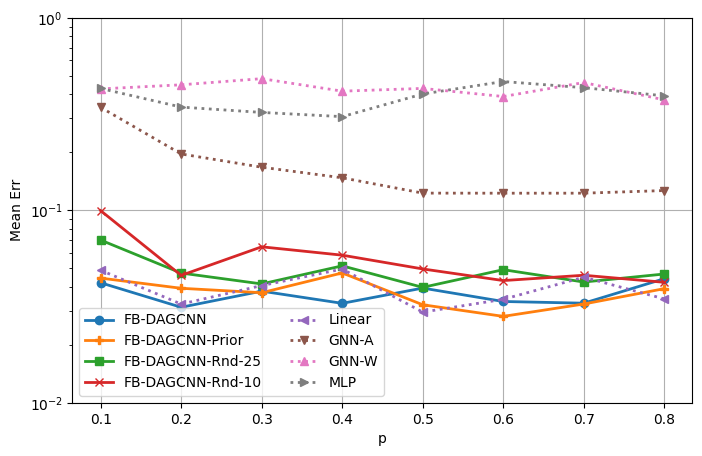

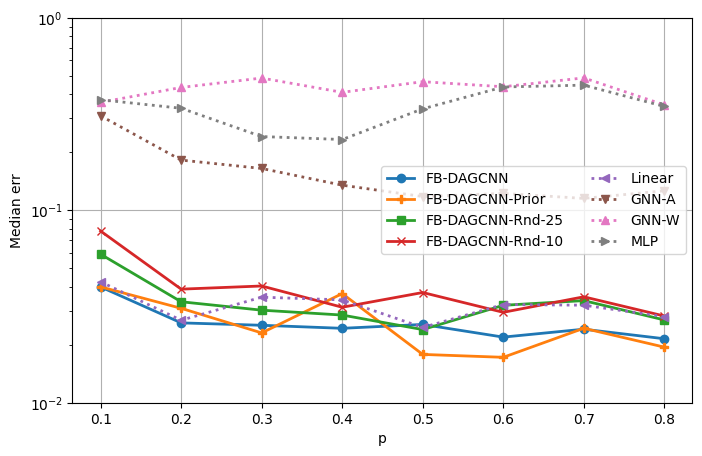

In [24]:
if SAVE:
    file_name = PATH + f'density_inf-{data_p["src_t"]}'
    np.savez(file_name, err=err, std=std, times=times, exp=Exps, xvals=P_values)
    print('SAVED FILE:', file_name)

mean_err = err.mean(axis=0)
mean_time = times.mean(axis=0)
med_err = np.median(err, axis=0)
legend = [exp['leg'] for exp in Exps]
utils.plot_results(mean_err, P_values, Exps, 'p', skip_idx=[], n_cols=2)
# utils.plot_results(mean_time, N_nodes, Exps, 'Number of layer', ylabel='Mean time (seg)',
#                    skip_idx=skip_idx, n_cols=2, ylim_bottom=1, ylim_top=50)

utils.plot_results(med_err, P_values, Exps, 'p', skip_idx=[], n_cols=2,
                   ylabel='Median err')

In [23]:
# file_name = PATH + 'density_inf-constant.npz'
# err, std, times, Exps, P_values = utils.load_data(file_name)

### Varying the size of the graph

In [12]:
def influence_graph_size(d_dat_p, d_arc_p, d_mod_p, N_nodes, exps):
    err = np.zeros((d_dat_p['n_tries'], len(N_nodes), len(exps)))
    std = np.zeros((d_dat_p['n_tries'], len(N_nodes), len(exps)))
    times = np.zeros((d_dat_p['n_tries'], len(N_nodes), len(exps)))
    
    t_begin = time.time()
    for i in range(d_dat_p['n_tries']):
        print('Realization:', i)

        for j, n_nodes in enumerate(N_nodes):
            data_params_aux = dict(d_dat_p)
            data_params_aux['N'] = n_nodes
            # Always use second half of nodes to generate data
            data_params_aux['max_GSO'] = n_nodes
            data_params_aux['min_GSO'] = int(n_nodes/2)
            available_nodes = data_params_aux['max_GSO'] - data_params_aux['min_GSO']
            data_params_aux['n_GSOs'] = min(d_dat_p['n_GSOs'], available_nodes)

            Adj, W, GSOs, Psi = utils.get_graph_data(data_params_aux, get_Psi=True)

            err[i,j], std[i,j], times[i,j] = run_exps(exps, d_arc_p, d_mod_p, data_params_aux, GSOs, W,
                                                      Adj, exp_desc=str(Adj.shape[0]), Psi=Psi)

            err[i,j][err[i,j] > 1] = 1

    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')

    return err, std, times

In [13]:
N_nodes = [25, 50, 100, 200, 400]

Exps = [

    # {'arc_p': {'arch': DAGConv, 'GSO': 'GSOs'}, 'leg': 'FB-DAGCNN', 'fmt': 'o--'},

    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'leg': 'FB-DAGCNN', 'fmt': 'o-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'sel_GSOs'}, 'leg': 'FB-DAGCNN-Prior', 'fmt': 'P-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 25}, 'leg': 'FB-DAGCNN-Rnd-25',
     'fmt': 's-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 10}, 'leg': 'FB-DAGCNN-Rnd-10',
     'fmt': 'x-'}, 

    # {'arc_p': {'arch': SF_DAGConv, 'GSO': 'GSOs'}, 'leg': 'SF-DAGCNN', 'fmt': '<:'},

    {'arc_p': {'arch': LinDAGRegModel}, 'leg': 'Linear', 'fmt': '<:'},
    {'arc_p': {'arch': MyGCNN, 'GSO': 'A'}, 'leg': 'GNN-A', 'fmt': 'v:'},
    {'arc_p': {'arch': MyGCNN, 'GSO': 'W'}, 'leg': 'GNN-W',  'fmt': '^:'},
    {'arc_p': {'arch': MLP, 'GSO': None}, 'leg': 'MLP',  'fmt': '>:'},
]

err, std, times = influence_graph_size(data_p, default_arch_p, default_mod_p, N_nodes, Exps)


Realization: 0
	-25. FB-DAGCNN: err: 0.037 - time: 3.2
	-25. FB-DAGCNN-Prior: err: 0.049 - time: 3.4
	-25. FB-DAGCNN-Rnd-25: err: 0.047 - time: 2.8
	-25. FB-DAGCNN-Rnd-10: err: 0.085 - time: 2.8
	-25. Linear: err: 0.049 - time: 0.0
	-25. GNN-A: err: 0.755 - time: 3.0
	-25. GNN-W: err: 0.775 - time: 2.0
	-25. MLP: err: 0.726 - time: 1.2
	-50. FB-DAGCNN: err: 0.055 - time: 3.0
	-50. FB-DAGCNN-Prior: err: 0.040 - time: 3.6
	-50. FB-DAGCNN-Rnd-25: err: 0.058 - time: 3.6
	-50. FB-DAGCNN-Rnd-10: err: 0.110 - time: 3.2
	-50. Linear: err: 0.034 - time: 0.1
	-50. GNN-A: err: 0.197 - time: 3.1
	-50. GNN-W: err: 0.628 - time: 3.5
	-50. MLP: err: 0.230 - time: 2.2
	-100. FB-DAGCNN: err: 0.031 - time: 3.9
	-100. FB-DAGCNN-Prior: err: 0.020 - time: 3.6
	-100. FB-DAGCNN-Rnd-25: err: 0.047 - time: 3.7
	-100. FB-DAGCNN-Rnd-10: err: 0.046 - time: 3.4
	-100. Linear: err: 0.057 - time: 0.3
	-100. GNN-A: err: 0.233 - time: 3.3
	-100. GNN-W: err: 0.856 - time: 1.6
	-100. MLP: err: 0.083 - time: 1.7
	-200. F

/home/srey/Investigacion/dag_conv_nn/src/dag_utils.py:148: RuntimeWarning: invalid value encountered in divide
  Y = Y / signal_norm


	-25. FB-DAGCNN-Prior: err: 0.789 - time: 1.0
	-25. FB-DAGCNN-Rnd-25: err: 0.041 - time: 3.8
	-25. FB-DAGCNN-Rnd-10: err: 0.071 - time: 3.3
	-25. Linear: err: 0.051 - time: 0.0
	-25. GNN-A: err: 0.994 - time: 3.2
	-25. GNN-W: err: 0.346 - time: 2.6
	-25. MLP: err: 0.908 - time: 1.8
	-50. FB-DAGCNN: err: 0.071 - time: 3.2
	-50. FB-DAGCNN-Prior: err: 0.099 - time: 3.1
	-50. FB-DAGCNN-Rnd-25: err: 0.127 - time: 3.0
	-50. FB-DAGCNN-Rnd-10: err: 0.093 - time: 2.8
	-50. Linear: err: 0.065 - time: 0.1
	-50. GNN-A: err: 0.333 - time: 3.2
	-50. GNN-W: err: 0.393 - time: 3.5
	-50. MLP: err: 0.405 - time: 2.3
	-100. FB-DAGCNN: err: 0.023 - time: 3.8
	-100. FB-DAGCNN-Prior: err: 0.063 - time: 2.7
	-100. FB-DAGCNN-Rnd-25: err: 0.061 - time: 3.0
	-100. FB-DAGCNN-Rnd-10: err: 0.083 - time: 2.9
	-100. Linear: err: 0.021 - time: 0.3
	-100. GNN-A: err: 0.282 - time: 3.1
	-100. GNN-W: err: 0.392 - time: 2.8
	-100. MLP: err: 0.309 - time: 2.3
	-200. FB-DAGCNN: err: 0.012 - time: 9.2
	-200. FB-DAGCNN-Prior

SAVED FILE: results/diffusion/n_nodes_inf-constant


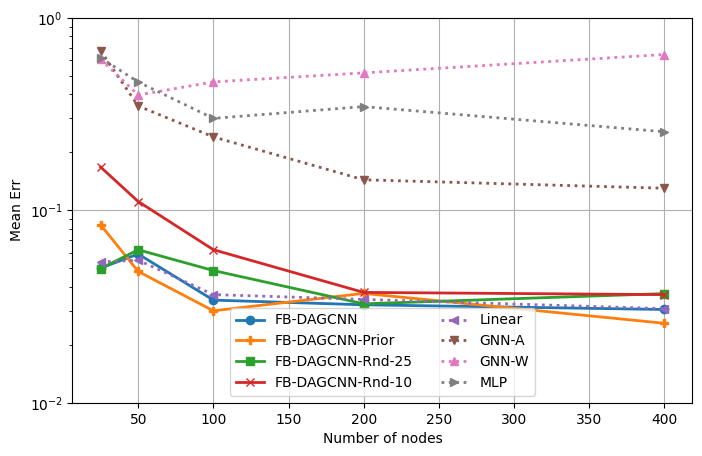

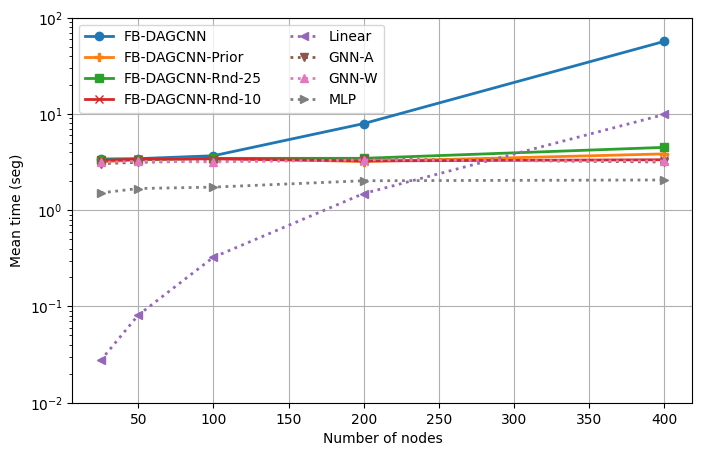

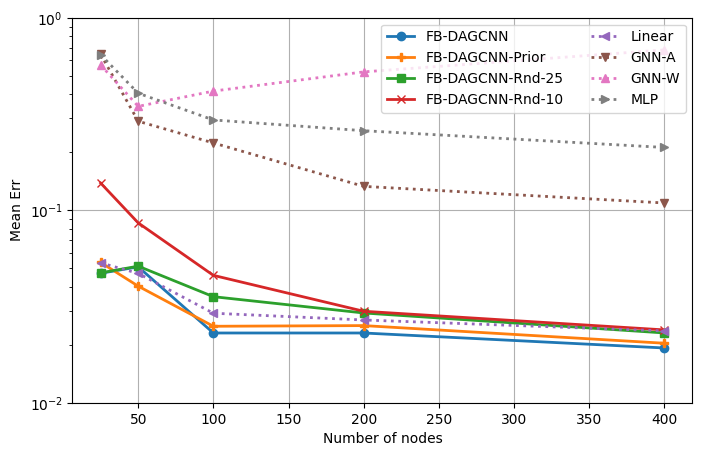

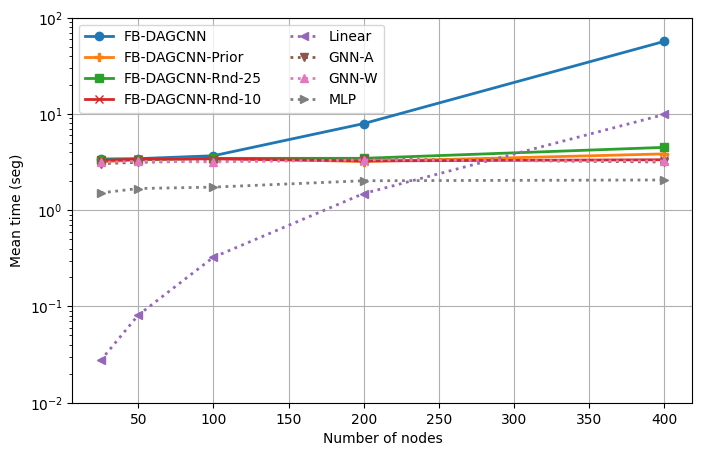

In [13]:
if SAVE:
    file_name = PATH + f'n_nodes_inf-{data_p["src_t"]}'
    np.savez(file_name, err=err, std=std, times=times, exp=Exps, xvals=N_nodes)
    print('SAVED FILE:', file_name)

mean_err = err.mean(axis=0)
mean_time = times.mean(axis=0)
med_err = np.median(err, axis=0)
legend = [exp['leg'] for exp in Exps]
utils.plot_results(mean_err, N_nodes, Exps, 'Number of nodes', skip_idx=[], n_cols=2)
utils.plot_results(mean_time, N_nodes, Exps, 'Number of nodes', ylabel='Mean time (seg)',
                   plot_fn=plt.semilogy, logy=False, n_cols=2, ylim_bottom=.01,
                   ylim_top=100)

utils.plot_results(med_err, N_nodes, Exps, 'Number of nodes', skip_idx=[], n_cols=2)
utils.plot_results(mean_time, N_nodes, Exps, 'Number of nodes', ylabel='Mean time (seg)',
                   plot_fn=plt.semilogy, logy=False, n_cols=2, ylim_bottom=.01,
                   ylim_top=100)

In [10]:
# file_name = PATH + 'n_nodes_inf-constant.npz'
# err, std, times, Exps, N_nodes = utils.load_data(file_name)

## Noise Influence

In [16]:
def influence_noise(d_dat_p, d_arc_p, d_mod_p, Noise_values, exps):
    err = np.zeros((d_dat_p['n_tries'], len(Noise_values), len(exps)))
    std = np.zeros((d_dat_p['n_tries'], len(Noise_values), len(exps)))
    times = np.zeros((d_dat_p['n_tries'], len(Noise_values), len(exps)))
    
    t_begin = time.time()
    for i in range(d_dat_p['n_tries']):
        print('Realization:', i)

        for j, noise in enumerate(Noise_values):
            data_params_aux = dict(d_dat_p)
            data_params_aux['n_p'] = noise

            Adj, W, GSOs, Psi = utils.get_graph_data(data_params_aux, get_Psi=True)

            err[i,j], std[i,j], times[i,j] = run_exps(exps, d_arc_p, d_mod_p, data_params_aux, GSOs, W,
                                                      Adj, exp_desc=str(noise), Psi=Psi)

            err[i,j][err[i,j] > 1] = 1

    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')

    return err, std, times

In [18]:
Noise_values = np.arange(0, .41, .05)

Exps = [
    {'arc_p': {'arch': DAGConv, 'GSO': 'GSOs'}, 'leg': 'DAGCNN', 'fmt': 'o--'},

    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'leg': 'FB-DAGCNN', 'fmt': 'o-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'sel_GSOs'}, 'leg': 'FB-DAGCNN-Prior', 'fmt': 'P-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 25}, 'leg': 'FB-DAGCNN-Rnd-25',
     'fmt': 's-'},

    {'arc_p': {'arch': SF_DAGConv, 'GSO': 'GSOs'}, 'leg': 'SF-DAGCNN', 'fmt': '<:'},

    {'arc_p': {'arch': LinDAGRegModel}, 'leg': 'Linear', 'fmt': '<:'},
    {'arc_p': {'arch': MyGCNN, 'GSO': 'A'}, 'leg': 'GNN-A', 'fmt': 'v:'},
    {'arc_p': {'arch': MLP, 'GSO': None}, 'leg': 'MLP',  'fmt': '>:'},
    {'arc_p': {'arch': GAT, 'GSO': 'A-dgl', 'n_heads': 2, 'hid_dim': 16, 'gat_params': {'attn_drop': 0}},
     'leg': 'GAT-A', 'fmt': '^:'},
    {'arc_p': {'arch': GraphSAGE, 'GSO': 'A-dgl', 'hid_dim': 16, 'agg': 'mean'}, 'leg': 'GraphSAGE-A',
     'fmt': 'P:'},
]

# err, std, times = influence_noise(data_p, default_arch_p, default_mod_p, Noise_values, Exps)


SAVED FILE: results/diffusion/noise_inf-constant


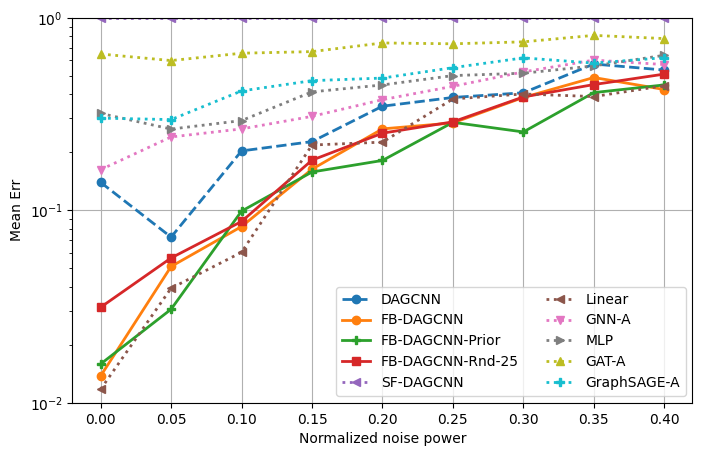

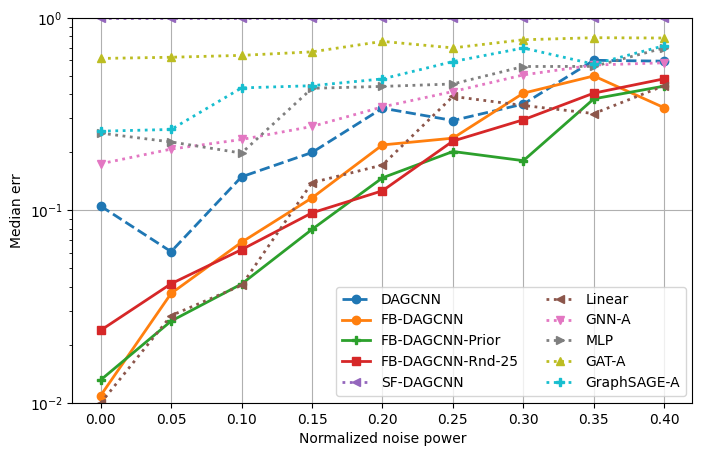

In [21]:
if SAVE:
    file_name = PATH + f'noise_inf-{data_p["src_t"]}'
    np.savez(file_name, err=err, std=std, times=times, exp=Exps, xvals=Noise_values)
    print('SAVED FILE:', file_name)

mean_err = err.mean(axis=0)
mean_time = times.mean(axis=0)
med_err = np.median(err, axis=0)
legend = [exp['leg'] for exp in Exps]
utils.plot_results(mean_err, Noise_values, Exps, 'Normalized noise power', skip_idx=[], n_cols=2)
# utils.plot_results(mean_time, Noise_values, Exps, 'Normalized noise power', ylabel='Mean time (seg)',
#                    skip_idx=[], n_cols=2, ylim_bottom=1, ylim_top=50)
utils.plot_results(med_err, Noise_values, Exps, 'Normalized noise power', ylabel='Median err',
                   n_cols=2)


In [16]:
# file_name = PATH + 'noise_inf-constant.npz'
# err, std, times, Exps, Noise_values = utils.load_data(file_name)